# Some Context

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats.

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

The different variables in the dataframe are the following ones:

* **userid:** A unique number that identifies each player.
  
* **version:** Control group (a gate at level 30) or the test group (a gate at level 40).
  
* **sum_gamerounds**: The number of game rounds played by the player during the first 7 days.
  
* **retention_1:** The player come back 1 day after the installation (True) or not (False)
  
* **retention_7:** The player come back 7 days after the installation (True) or not (False)

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Let's see if there are some user duplicated

In [6]:
df['userid'].duplicated().any()

False

Since the userID doesn't contribute anything to the analysis, let's drop the column.

In [7]:
df = df.drop(labels = 'userid' , axis = 1)

In [8]:
df.head()

,version,sum_gamerounds,retention_1,retention_7
0,gate_30,3,False,False
1,gate_30,38,True,False
2,gate_40,165,True,False
3,gate_40,1,False,False
4,gate_40,179,True,True


In [9]:
df.describe()

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


#### Game Round

In [10]:
df.groupby('version')['sum_gamerounds'].agg(['count','mean','median','min','max'])

,count,mean,median,min,max
version,,,,,
gate_30,44700,52.456264,17.0,0,49854
gate_40,45489,51.298776,16.0,0,2640


Comparing the mean and the median, we can see that there are a big difference between them. The mean are very affectet by outliers, while the median not.

Since the statistical tests are also affected by outliers, let's manage them.

In [13]:
# Identifying thresholds
# 75Th percentile
seventy_fifth = df['sum_gamerounds'].quantile(0.75)
#25th percentile
twenty_fifth = df['sum_gamerounds'].quantile(0.25)
# Interquartile range
gamerounds_iqr = seventy_fifth - twenty_fifth

# Identifying outliers
# Upper threshold
upper = seventy_fifth + (1.5 * gamerounds_iqr)
# Lower threshold
lower = twenty_fifth - (1.5 * gamerounds_iqr)
print(upper,lower)

120.0 -64.0


In [14]:
Outliers_percent = len(df[df['sum_gamerounds']>120]['sum_gamerounds'])/len(df) * 100
Outliers_percent

11.284081207242568

Removing 11% of the data may be too aggressiv, so the dessicion of droping the data depends on:


* Distribution of the data: If the data is normally distributed or close to a normal distribution, removing 11% of the data may be too aggressive, as it could eliminate valid values that are simply at the extremes of the distribution.



* Impact on the analysis: Removing 11% of the data can significantly affect the results of the analysis, especially if the data sample is small. Before removing outliers, it is important to assess how this will affect the final analysis results and whether it is necessary to adjust the approach or consider alternative methods for dealing with them.




* Nature of the outliers: It is important to consider whether the outliers identified are truly anomalies or if they are simply valid but extreme values. In some cases, outliers may contain important or meaningful information that should not be discarded without careful evaluation.


To avoid problems let's see the outliers more detailed

In [15]:
df[df['sum_gamerounds']>120]['sum_gamerounds'].sort_values()

34383      121
60004      121
78592      121
63275      121
48580      121
         ...  
48188     2294
43671     2438
29417     2640
7912      2961
57702    49854
Name: sum_gamerounds, Length: 10177, dtype: int64

<Axes: ylabel='sum_gamerounds'>

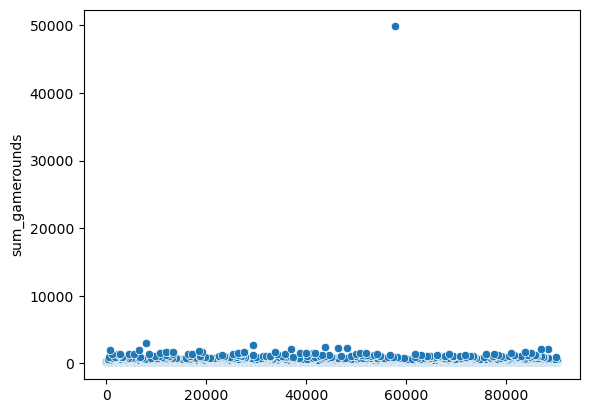

In [16]:
sns.scatterplot(df[df['sum_gamerounds']>120]['sum_gamerounds'].sort_values())

We see that there are one highly extream value.

Let's drop it:

In [17]:
df_clean = df.drop(df[df['sum_gamerounds']>10000].index)

<Axes: xlabel='None', ylabel='sum_gamerounds'>

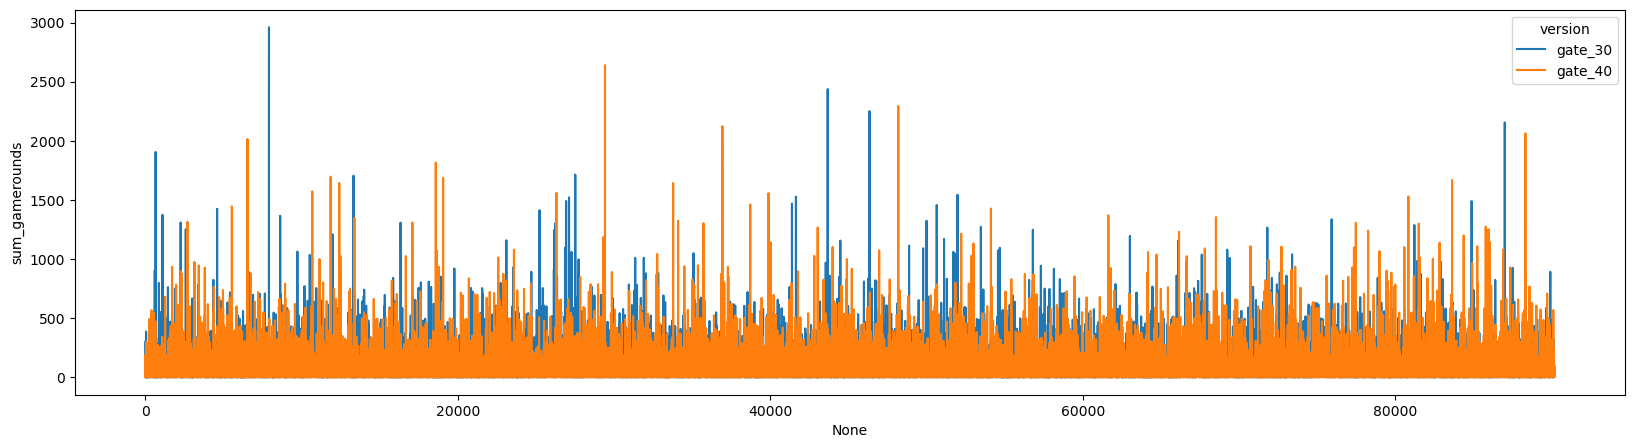

In [18]:
fig, ax =  plt.subplots(figsize=(20,5))
sns.lineplot(x=df_clean.index, y = 'sum_gamerounds', data = df_clean, hue = 'version')

(0.0, 125.0)

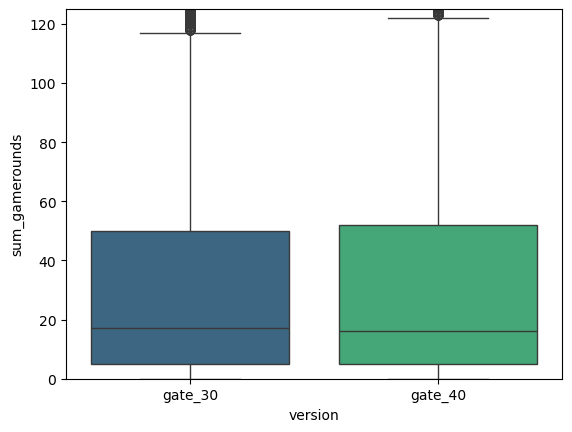

In [22]:
sns.boxplot(x = 'version', y ='sum_gamerounds', data = df_clean, palette ='viridis')
plt.ylim(0,125)

Text(0, 0.5, 'Game Rounds average')

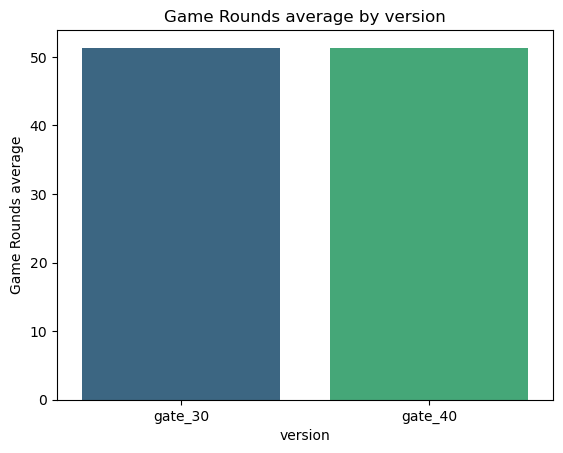

In [27]:
fig, ax = plt.subplots()
sns.barplot(x = pd.DataFrame(df_clean.groupby('version')['sum_gamerounds'].mean()).index, y = 'sum_gamerounds',data = pd.DataFrame(df_clean.groupby('version')['sum_gamerounds'].mean()),palette ='viridis')
ax.set_title('Game Rounds average by version')
ax.set_ylabel('Game Rounds average')

#### Retention 1 day

In [28]:
retention_1_day = pd.DataFrame(df_clean.groupby('version').agg({'retention_1':[('Retained','sum'),('Total','count'),('Retention rate',lambda x: (x.sum() / x.count())),('Chrun rate', lambda x: (1-(x.sum() / x.count())))]}))
retention_1_day

retention_1                                 
           Retained  Total Retention rate Chrun rate
version                                             
gate_30       20034  44699       0.448198   0.551802
gate_40       20119  45489       0.442283   0.557717

For gate at level 30 the percentage of retention after 1 day is 44.81%

For gate at level 40 the percentage of retention after 1 day is 44.22%

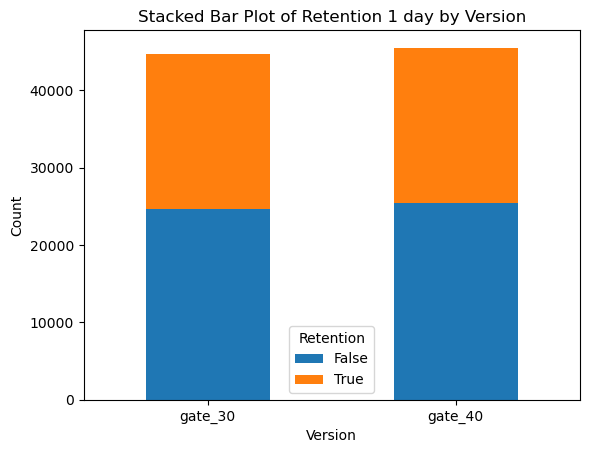

In [31]:
stacked_data = df_clean.groupby('version')['retention_1'].value_counts().unstack()
stacked_data.plot(kind='bar', stacked = True)
plt.title('Stacked Bar Plot of Retention 1 day by Version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.legend(title = 'Retention')
plt.xticks(rotation = 0)
plt.show()

#### Retantion 7 days

In [32]:
df_clean.groupby('version').agg({'retention_7':[('Retained','sum'),('Total','count'),('Retention rate',lambda x:(x.sum() / x.count())),('Churn rate',lambda x:(1-(x.sum() / x.count())))]})

retention_7                                 
           Retained  Total Retention rate Churn rate
version                                             
gate_30        8501  44699       0.190183   0.809817
gate_40        8279  45489       0.182000   0.818000

For gate at level 30 the percentage of retention after 7 days is 19.01%

For gate at level 40 the percentage of retention after 7 days is 18.20%

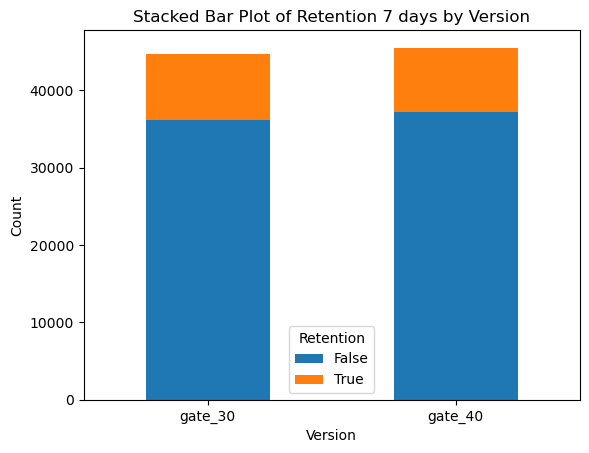

In [34]:
stacked_data = df_clean.groupby('version')['retention_7'].value_counts().unstack()
stacked_data.plot(kind = 'bar', stacked = True)
plt.title('Stacked Bar Plot of Retention 7 days by Version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.legend(title='Retention')
plt.xticks(rotation = 0)
plt.show()

#### Resume

In [36]:
pd.DataFrame({"RET1_COUNT": df_clean["retention_1"].value_counts(),
              "RET7_COUNT": df_clean["retention_7"].value_counts(),
              "RET1_RATIO": df_clean["retention_1"].value_counts() / len(df_clean),
              "RET7_RATIO": df_clean["retention_7"].value_counts() / len(df_clean)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


Now that we have analysize the data, let's perform the A/B test with the hyothesis test.

#### A/B Test

First, let's check the asumptions:



To run a parametric hypothesis test we must ensure that the assumptions are met. The assumptions are:



* **Randomness:** The samples are random subsets of larger populations.


* **Independence of observations:** Each observation (row) in the dataset is independent.



* **Large sample size:** The sample is big enough to mitigate uncertainty, so that the Central Limit Theorem applies. The number of observations depends on the statistical test performed.




* **Normal distribution:** The distribution of the data should follow a normal distribution.



* **Homogeneity of variances:** The variances of the groups or samples being compared should be approximately equal.


The first three assumptions are met. Let's see the next two

#### Retention 1 day

In [38]:
from scipy.stats import shapiro, levene

# Normality assumption:
# H0: Distribution is Normal
# H1: Distribution is not Normal

shapiro_stat_30,shapiro_p_value_30 = shapiro(df_clean[df_clean['version']== 'gate_30']['retention_1'])
shapiro_stat_40,shapiro_p_value_40 = shapiro(df_clean[df_clean['version']== 'gate_40']['retention_1'])
print(f'Shapiro-Wilk test for normality (Gate 30):p-value ={shapiro_p_value_30}')
print(f'Shapiro-Wilk test for normality (Gate 40): p-value ={shapiro_p_value_40}')

# Homogeneity of variances:
# H0: Homogeneity
# H1: Heterogeneous

levene_stat, levene_p_value = levene(df_clean[df_clean['version'] == 'gate_30']['retention_1'],df_clean[df_clean['version'] == 'gate_40']['retention_1'])
print(f"Levene's test for equality of variances: p-value ={levene_p_value}")

Shapiro-Wilk test for normality (Gate 30):p-value =0.0
Shapiro-Wilk test for normality (Gate 40): p-value =0.0
Levene's test for equality of variances: p-value =0.07392220630215537


A p-value of 0.0 in the Shapiro-Wilk tests for normality indicates that there is significant evidence to reject the null hypothesis of normality. This suggests that the data in both groups do not follow a normal distribution. Regarding the result of Levene's test for the equality of variances, a p-value of 0.0739 indicates that there is not enough evidence to reject the null hypothesis of equal variances. This suggests that the two groups may have equal variances.







Therefor, let's perform a Non-parametric test.



As we are comparing the proportions of successes of one categorical variable between the categories of another categorical variable, let's perform a Fisher exact test:

In [40]:
from scipy.stats import fisher_exact

# Contingency table
contingency_table = pd.crosstab(df_clean['version'],df_clean['retention_1'])

# Fisher exact test
# H0: p1 = p2
# H1: p1 != p2

odds_ratio, p_value = fisher_exact(contingency_table)
print("Result from Fisher exact test:")
print("Odds ratio:", odds_ratio)
print("P-value:", p_value)

Result from Fisher exact test:
Odds ratio: 0.9763361587626617
P-value: 0.07470295380924759


n this case, the null hypothesis would be that the game version (gate_30 and gate_40) and retention after 1 day (True or False) are independent of each other.

In other words, the null hypothesis asserts that the proportion of players retaining the game after 1 day is the same regardless of the game version they are using

In [42]:
# Normality assumption:
# H0: Distribution is Normal
# H1: Distribution is not Normal

shapiro_stat_30,shapiro_p_value_30 = shapiro(df_clean[df_clean['version']== 'gate_30']['retention_7'])
shapiro_stat_40,shapiro_p_value_40 = shapiro(df_clean[df_clean['version']== 'gate_40']['retention_7'])
print(f'Shapiro-Wilk test for normality (Gate 30):p-value ={shapiro_p_value_30}')
print(f'Shapiro-Wilk test for normality (Gate 40): p-value ={shapiro_p_value_40}')

# Homogeneity of variances:
# H0: Homogeneity
# H1: Heterogeneous

levene_stat, levene_p_value = levene(df_clean[df_clean['version'] == 'gate_30']['retention_7'],df_clean[df_clean['version'] == 'gate_40']['retention_7'])
print(f"Levene's test for equality of variances: p-value ={levene_p_value}")

Shapiro-Wilk test for normality (Gate 30):p-value =0.0
Shapiro-Wilk test for normality (Gate 40): p-value =0.0
Levene's test for equality of variances: p-value =0.0015915357297900119


In this case, both samples are non normally distributed and have heterogeneity of variances.

Therefore we are going to perform a non paramtric test. In the same way as before, let's performa Fisher exact test.

In [43]:
# Contingency table
contingency_table = pd.crosstab(df_clean['version'],df_clean['retention_7'])

# Fisher exact test
# H0: p1 = p2
# H1: p1 != p2

odds_ratio, p_value = fisher_exact(contingency_table)
print("Result from Fisher exact test:")
print("Odds ratio:", odds_ratio)
print("P-value:", p_value)

Result from Fisher exact test:
Odds ratio: 0.947398673017617
P-value: 0.0016378383114174855


Since the p-value is less than the significance level of 0.05, we reject the null hypothesis. In other words, there is enough evidence to assert that the retention proportion after 7 days differs between the two versions of the game. This suggests that the game version may have a significant effect on player retention after 7 days.

#### Game Rounds:

In [44]:
# Normality assumption:
# H0: Distribution is Normal
# H1: Distribution is not Normal

shapiro_stat_30,shapiro_p_value_30 = shapiro(df_clean[df_clean['version']== 'gate_30']['sum_gamerounds'])
shapiro_stat_40,shapiro_p_value_40 = shapiro(df_clean[df_clean['version']== 'gate_40']['sum_gamerounds'])
print(f'Shapiro-Wilk test for normality (Gate 30):p-value ={shapiro_p_value_30}')
print(f'Shapiro-Wilk test for normality (Gate 40): p-value ={shapiro_p_value_40}')

# Homogeneity of variances:
# H0: Homogeneity
# H1: Heterogeneous

levene_stat, levene_p_value = levene(df_clean[df_clean['version'] == 'gate_30']['sum_gamerounds'],df_clean[df_clean['version'] == 'gate_40']['sum_gamerounds'])
print(f"Levene's test for equality of variances: p-value ={levene_p_value}")

Shapiro-Wilk test for normality (Gate 30):p-value =0.0
Shapiro-Wilk test for normality (Gate 40): p-value =0.0
Levene's test for equality of variances: p-value =0.7840494387892463


In both versions, the variable 'sum_gamerounds' is non-normally distributed based on the p-value from the Shapiro-Wilk test, which provides strong evidence to reject the null hypothesis that the data are normally distributed. However, the two versions for the gamerounds have homogeneous variance based on Levene's test, which does not provide strong evidence to reject the null hypothesis of homogeneity of variances.

Therefore, let's perform a non parametrical test. As we are comparing the mean of gamerounds, let's performa a Wilcoxon-Mann-Whitney U test

In [47]:
from scipy.stats import mannwhitneyu

group_30 = df_clean[df_clean['version'] == 'gate_30']['sum_gamerounds']
group_40 = df_clean[df_clean['version'] == 'gate_40']['sum_gamerounds']

# Mann-Whitney U
statistic, p_value = mannwhitneyu(group_30, group_40)

print("Mann-Whitney U statistic:", statistic)
print("P-value:", p_value)

Mann-Whitney U statistic: 1024285761.5
P-value: 0.05089155279145376


Since the p-value is greater than the significance level of 0.05, there is not enough evidence to reject the null hypothesis. Therefore, we cannot conclude that there is a significant difference between the distributions of 'sum_gamerounds' for the 'gate_30' and 'gate_40' versions.

# Conlusions

After conducting an exploratory analysis and the pertinent hypothesis tests, the conclusions are as follows:



* Changing the gate from level 30 to level 40 does not have a significant effect on the retention rate after 1 day nor on the number of rounds played by the users.




* Changing the gate from level 30 to level 40 has a significant effect on the retention of the users 7 days after the installation of the game. However, upon examining the retention proportions, we observe a very small difference between gate_30 (19.01%) and gate_40 (18.20%), with gate_30 performing slightly better.




Therefore, the company should not change the gate level from 30 to 40.